In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter
    <a href=\"https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/\">extensions</a>.
</div>

# SIRD parameter learning using FISTA with Tikhonov regularisation

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [0,1]^2} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2 + \frac{\theta}{2} \|\alpha\|^2,
\end{align}
where $\rho = (\begin{smallmatrix} S & I & R \end{smallmatrix})$ comes from the solution of the traditional forward Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state. The regularisation parameter $\theta$ is non negative. We will study the effect of this parameter on the choice of the control pair $\alpha$.
    
For each triplet of parameters $\alpha = (\beta, \gamma,m) \in [0,1]^3$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \frac{\dif S}{\dif t} &= -\beta S I,
    \\
    \frac{\dif I}{\dif t} &= \beta S I - (\gamma+m) I,
    \\
    \frac{\dif R}{\dif t} &= \gamma I.
\end{align}
    
We note that $S + I + R = n$, where $n$ is the total population. 
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, ones, allclose, arctan, exp, pi, append, arange
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals
from scipy.integrate import simpson
from scipy.optimize  import minimize, Bounds
from scipy.interpolate import CubicHermiteSpline
from numpy.polynomial.chebyshev import chebpts1
from matplotlib import colormaps

# Problem setup

In [4]:
# Total population
n = 400
# Initial conditions
f = 5e-2
Sₒ, Iₒ, Rₒ = (1-f)*n, f*n, 0.0    # These are for reference, changing them won't affect the later code

## Generation of $\widehat \rho$

We are going to generate a choice for $\widehat\rho$ based on a solution of the system that satisfies the initial condition. For this, we find $\widehat\rho_{\mathsf e}$ as the solution of the SIR model for the choice $\alpha = (0.01,0.5)$. Then we compute the smooth transformation $p_1 = \widehat{\rho}_{\mathsf e} + 4 \big(\sin(\widehat{\rho}_{\mathsf e}) - \sin(\rho_0) \big)$.

In [5]:
T  = 3                             # Final time
Tₑ = 0.5*(chebpts1(200)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])     # Add endpoints

In [6]:
# Rates for ρ̂ₑ:
βₑ, γₑ, mₑ = 0.007, 0.1, 0.05
αₑ = asarray([βₑ, γₑ, mₑ])

In [7]:
print('Basic reproduction number:', n*βₑ/(γₑ+mₑ))

Basic reproduction number: 18.666666666666664


In [8]:
def SIRD(t, z, β,γ,m):
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [9]:
sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=(βₑ, γₑ, mₑ), t_eval = Tₑ, dense_output=True, vectorized=True)
print(sol['message'])

The solver successfully reached the end of the integration interval.


In [10]:
ρ̂ₑ  = sol.y;    ρ = ρ̂ₑ.copy()
dρ̂ₑ = asarray(SIRD(0,ρ̂ₑ,βₑ,γₑ,mₑ))

Apply smooth transformation:

In [11]:
p_1 = ρ̂ₑ + 4*sin(ρ̂ₑ) - 4*sin(ρ̂ₑ[:,0])[::,np.newaxis]

Now we split the integral $[0,T]$ into $k$ periods and compute the rolling average of $p_1$ on each subinterval yielding a vector:
\begin{align*}
    (p_2)_i = \int\limits_{t_{i}}^{t_{i+1}} \frac{p_1}{t_{i+1} - t_i} \, \mathrm{d} s  \qquad \qquad \forall i \in [0:k-1].
\end{align*}

In [12]:
from scipy.integrate import quad_vec

In [13]:
SmoothVar = lambda t: sol.sol(t) + 4 * sin(sol.sol(t) - 4 * sin(ρ̂ₑ[:,0]) )

In [14]:
num_subintervals = 50
t_values = np.linspace(0, T, num_subintervals + 1)

In [15]:
IntQUADPACK = [quad_vec(SmoothVar, t_values[i], t_values[i+1], full_output=False)   for i in range(num_subintervals)]
averages    = asarray([IntQUADPACK[i][0]    for i in range(num_subintervals)]) / ( t_values[1] - t_values[0] )
print('Maximum integration error estimate: {0:.2e}'.format(asarray([IntQUADPACK[i][1]    for i in range(num_subintervals)]).max()) )

Maximum integration error estimate: 8.97e-09


Now let's keep monotony of the function: (a) susceptibles cannot increase, (b) recovered cannot decrease, (c) infected cannot decrease until the peak is reached.

In [16]:
MonAv = averages.copy()
for i in range(1,num_subintervals):
    # Susceptible
    if MonAv[i,0] > MonAv[i-1,0]:
        MonAv[i,0] = MonAv[i-1,0]
    # Recovered
    if MonAv[i,2] < MonAv[i-1,2]:
        MonAv[i,2] = MonAv[i-1,2]
    # Infected
    idx_cut = np.digitize(Tₑ[np.argmax(ρ̂ₑ.T[:,1])], t_values) - 1    # Compute maximal increase (based on original smooth curve)
    if i <= idx_cut:
        if MonAv[i,1] < MonAv[i-1,1]:
            MonAv[i,1] = MonAv[i-1,1]
    else:
        if MonAv[i,1] > MonAv[i-1,1]:
            MonAv[i,1] = MonAv[i-1,1]

Now produce an upper semicontinuous function from the average:
\begin{align*}
    \hat{\rho} = p_3(t) = \sum_{i=0}^{k-1} (p_2)_i \iota_{ t_{i+1} \leq t < t_i  } + (p_2)_{k-1} \iota_{t=T}.
\end{align*}

In [17]:
def averaged_ρ(t):
    # Ensure t is within the defined interval
    if np.any(t < 0) or np.any(t > T):
        raise ValueError("Some t values are out of bounds!")
    
    # Find the subinterval index:
    idx = np.digitize(t, t_values) - 1
    
    # Handle the edge case where t == T
    idx = np.where(t == T, len(MonAv) - 1, idx)
    
    return MonAv[idx].T

In [18]:
ρ̂ = averaged_ρ(Tₑ)
ρ̄ = averaged_ρ      # Functional representation

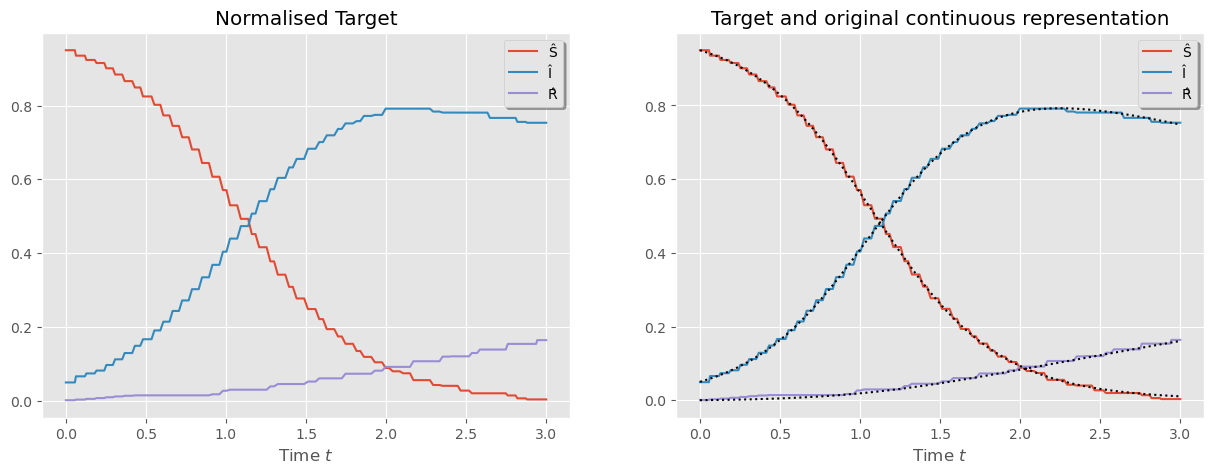

In [19]:
# Plot Target curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ̂.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.title('Normalised Target')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, ρ̂.T/n)
plt.plot(Tₑ, ρ̂ₑ.T/n, ':', c='black', linewidth=1.5)
plt.xlabel(r'Time $t$')
plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.title('Target and original continuous representation')
plt.show()

## Create a given state

In [20]:
# Give a random initial control
α = asarray([0.01,0.02,0.1])

In [21]:
# Compute state ρ(α)
ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                  dense_output=True, vectorized=True)
if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
ρ = ρ_sol.y

# Create an abstract interpolator for state
ρₜ = ρ_sol.sol    # CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)

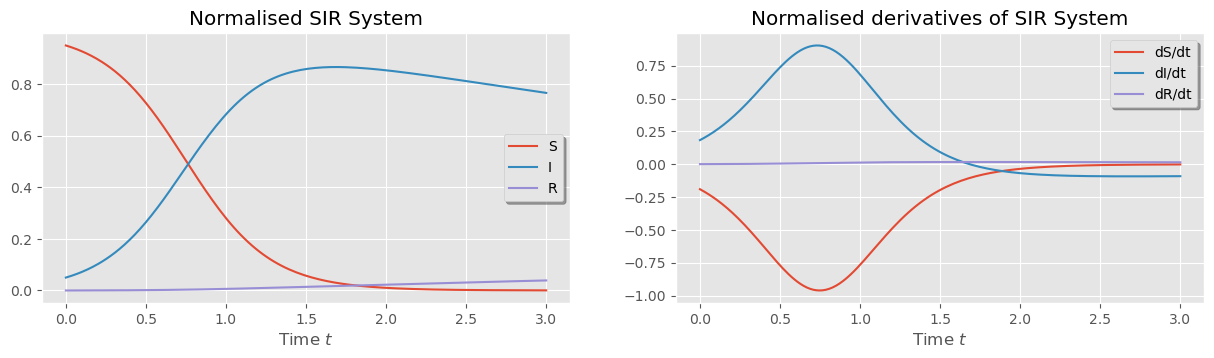

In [22]:
# Plot SIR curves
plt.figure(figsize=(15,3.5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIRD(0.0, ρ, α[0], α[1], α[2])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

## Adjoint system

The adjoint state can be found by solving the following ODE system:

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_S}{\dif t} &= \hat{S} - S +\beta I(q_S - q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I + \beta S(q_S - q_I) + \gamma (q_I - q_R) + m q_I,
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
\end{align}
with the terminal condition $q(T) = 0$.

Let us see how we can implement this with an adaptive step method:

In [23]:
def Adjoint(t, z, β,γ,m, ρ):
    S̄, Ī, R̄ = ρ̄(t)    # Target
    S, I, R = ρ(t)     # State
    qₛ, qᵢ, qᵣ = z     # Adjoint
    return [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]

Let us try solving this problem for $\rho = \widehat{\rho}$:

In [24]:
solₛ = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(0.1, 0.01,0.1, ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 446 function evaluations.


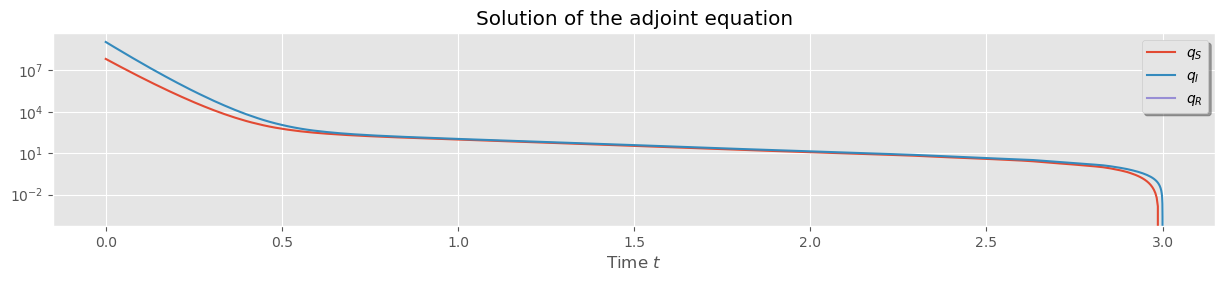

In [25]:
# Plot adjoint curves
plt.figure(figsize=(15,2.5))
plt.plot(Tₑ[::-1],solₛ.y.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
plt.title('Solution of the adjoint equation')
plt.yscale('log')
plt.show()

Now we try to optimise the function
\begin{align}
    f(\alpha) = \frac{1}{2} \int\limits_0^T \big( S(t) - \hat{S}(t) \big)^2 + \big( I(t) - \hat{I}(t) \big)^2 + \big( R(t) - \hat{R}(t) \big)^2 \,\dif t + \frac{\theta}{2} ( \beta^2 + \gamma^2 +m^2 ).
\end{align}

In [26]:
def Objective(ρ,ρ̂,α, θ):    return 0.5 * (simpson((ρ-ρ̂)**2,x=Tₑ).sum() + θ * (α**2).sum())

In [27]:
def proj(α):    return minimum(maximum(α,0.0),1.0)

In [28]:
print('As an example, the distance between ρ and ρ̂ is {0:.4f}.'.format( Objective(ρ,ρ̂,α,1e+3) ))

As an example, the distance between ρ and ρ̂ is 11594.7031.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} = \int\limits_0^T S I( q_I - q_S ) \, \dif t + \theta \beta,
    \qquad
    \frac{\partial f}{\partial \gamma} = \int\limits_0^T I( q_R - q_I ) \, \dif t  + \theta \gamma,
    \qquad
    \frac{\partial f}{\partial m} = \int\limits_0^T -I q_I  \, \dif t  + \theta m. 
\end{align}

In [29]:
q = solₛ.y[:,::-1]

In [30]:
θ = 0.0
df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ[1] * (q[2]-q[1]), x=Tₑ), -simpson(ρ[1] * q[1], x=Tₑ)])  + θ * α
display(df.tolist())

[251759367575.16415, -716288666.3516726, -716259675.1177481]

# Surfaces

We can observe what happens with the cost functional for different values of the hyperparameter $\alpha$:

In [31]:
θ = 0.0

In [32]:
global ρ, q
ρ = np.zeros_like(ρ̂)
q = np.zeros_like(ρ̂)

In [33]:
def obj_eval_a(α):                # ** Eval just j ** #
    global ρ
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α, θ*(n**2) if scaling else θ )
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)
def obj_eval(α):                  # ** Eval j and j' ** #
    global ρ, q
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α, θ*(n**2) if scaling else θ )
    f /= (n**2) if scaling else 1.0
    
    # Create an abstract interpolator for state
    #ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1],α[2])), axis=-1)
    # Alternative from ODE struct: 
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(α[0], α[1], α[2], ρₜ), t_eval = Tₑ[::-1], dense_output=False, vectorized=False)
    q = q_sol.y[:,::-1]

    # Compute derivative
    df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ[1] * (q[2]-q[1]), x=Tₑ), -simpson(ρ[1] * q[1], x=Tₑ)])
    df /= (n**2) if scaling else 1.0
    df += (θ * α)
    
    return asarray(f), df

In [34]:
# Optimal point should be around
# 0.007, 0.7, 0.3
# So we evaluate around this point

In [35]:
# Coarse evaluations (takes a long time)
nβ, nγ, nm = 41, 41, 31
Misfit = zeros([nβ, nγ, nm])
β_axis = linspace(0.001,0.15,nβ)
γ_axis = linspace(0.1,1,nγ)
m_axis = linspace(0.1,1,nm)
for (i,β) in enumerate(β_axis):
    #print(i)
    for (j,γ) in enumerate(γ_axis):
        for (k,m) in enumerate(m_axis):
            Misfit[i,j,k] = obj_eval_a( asarray([β,γ,m]) ).item()

In [36]:
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)
M_0, β_0, γ_0, m_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]],    m_axis[i_0[2]]
print('Smallest objective found in the mesh: {0:.4e} with (β,γ,m): ({1:.4f},{2:.4f},{3:.4f})'.format(M_0,β_0,γ_0, m_0))

Smallest objective found in the mesh: 7.2703e-03 with (β,γ,m): (0.0084,0.7750,0.5800)


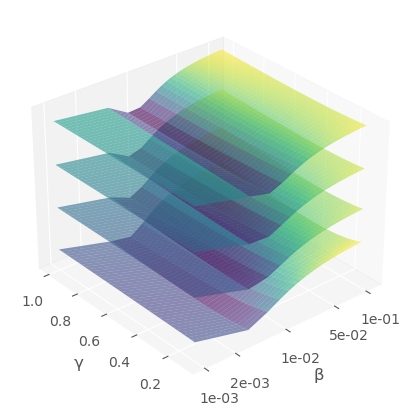

In [37]:
# Create grid of (β,γ)
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')

# Create a 3D plot
fig = plt.figure( figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot surfaces for each z value
for k in [0,10,20,30]:
    # Create a surface plot for each z value and stack them vertically
    ax.plot_surface(np.log(X_c), Y_c, Misfit[:,:,k]+k/10, cmap='viridis', alpha=0.6)

# Set axis labels and title
ax.set_xlabel('β')
ax.set_ylabel('γ')

#ax.set_zlabel('Z (graphically scaled)')
#ax.set_title('Stacked Surface Plots for varying $m$')

ax.view_init(elev=30, azim=230)
ax.set_box_aspect((2, 2, 1.5))

# Set the ticks
ax.set_xticks([-6.9,-6,-4.5,-3,-2]);    #ax.set_yticks([-2.3,-1.5,-0.5,0])
ax.set_xticklabels([f'{val:.0e}' for val in np.exp(ax.get_xticks())])
#ax.set_yticklabels([f'{val:.0e}' for val in np.exp(ax.get_yticks())])
ax.set_zticks([])
ax.set_facecolor('xkcd:white')
plt.show()

# Solving the optimisation problem

### Misfit with $\widehat{\rho}$

We will use a gradient-based algorithm for optimising $f$.

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Fast Iterative Shrinkage-Thresholding Algorithm</h2>
<ol>
<li>Let $\alpha_0 = \omega_0 \in [0,1]^2$, $\theta_0 = 1$, $L_0>0$, $\eta > 1$, and $a < 1$.</li>
<li>
    For any $L>0$ and $\alpha,\omega \in [0,1]^2$, define the functions
    \begin{align}
        p_L (\omega) &= \mathcal{P}_{[0,1]^2}[\omega - L^{-1} \nabla f(\omega) ],
    \\
        q_L (\omega,\alpha) &= f(\alpha) + \langle \omega-\alpha, \nabla f(\alpha) \rangle + \frac{L}{2} \|\omega-\alpha\|^2.
    \end{align}
</li>
    
<li>For $k \in \{0,\ldots\}$, do
<ol>
<li>Compute state $\rho_{\omega_k}$
<li>Compute adjoint $q_{\omega_k}$
<li>Evaluate the gradient of the reduced functional $ \nabla f(\omega_k)$

<li>Find the smallest $i_k \in \mathbb{N}$ such that
\begin{align}
    L &= \eta^{i_k} L_k
    \\
    f\big( p_L (\omega_k) \big) &\leq q_L \big( p_L(\omega_k), \omega_k  \big)
\end{align}
    
<li>Update $L_{k+1} = \eta^{i_k} L_k$
<li>Set $\alpha_{k+1} = p_{L_{k+1}} (\omega_k)$
<li>Update $\theta_{k+1} = a k + 1$
<li>Update $\omega_{k+1} = \alpha_{k+1} + \frac{\theta_k - 1}{\theta_{k+1}} (\alpha_{k+1} - \alpha_k)$
</li>
</ol>
</div>

Let's select a initial point at random:

In [35]:
# Initial point
β, γ, m = α = rng(80).uniform(0,1,3)
α[0] *= 0.1
α, γ + m

(array([0.07364913, 0.0184188 , 0.03663371]), 0.05505250620295099)

In [36]:
θ = 0.0
obj_eval_a(α)

array(0.63726528)

We will scale $\rho$ and $\widehat{\rho}$ by $n$.

In [37]:
def box_scale(x,y):
    '''
        Return minimum value of scalar s > 0  such that x + sy ∈ [0,1] for x ∈ [0,1]
    '''
    a = np.divide(x, y, where=(y>0))[y>0]
    b = np.divide((x-1), y, where=(y<0))[y<0]
    if len(a) > 0:
        if len(b) > 0:
            return min( a.min(), b.min() )
        else:
            return a.min()
    else:
        return b.min()

In [38]:
def FISTA(α, iters, save_iter = False, critical = 1, εₐ = 1e-9, εᵦ = 1e-16, try_TR = False):
    '''
        Create structures to store information from iterates
    '''
    every_iter = {
        'it':[], 'obj':[], 'time':[], 'β':[], 'γ':[], 'm':[], 'df_β':[], 'df_γ':[], 'df_m':[],
        'norms':{'ℓ_1': [], 'ℓ_2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'time':[], '|df|_2':[], '|df|_max':[]}
    
    '''
        GD iterates
    '''
    print('     It  |    f(ω)  |    Time   |  ‖df(ω)‖_2  |   ‖df(ω)‖_∞  ')
    print( '{:–^62}'.format('') )
    
    # Initialisation
    # 1.1, 0.965, 10, 11/5   [0.259914]
    # 1.01, 0.965, 10, 11/5  [0.107911]
    # Best so far
    # 1.01 0.1 10 11/5 [0.100978]
    
    ω = α.copy()
    θₖ = 1.0      # Inertia parameter (not to be confused with \theta)
    η = 1.01     # Scaling for backtracking
    L = 2.0#0.965     # Approximation of the Lipschitz constant
    I = 10       # Number of iterations for backtracking
    a = 11.0/5   # Inertia weight (a > 2)
    
    # First objective evaluation
    # Compute state and adjoint for ω
    f = obj_eval_a(α)
    
    timed = 0.0
    for k in range(iters):
        #print(L)
        α_o = α.copy()
        θ_o = θₖ
        f_o = f
        
        it_time = time.time()
        
        # Compute state and adjoint for ω
        f, df = obj_eval(ω)
        
        # Store info for initial point
        if k == 0 and save_iter:
            every_iter['it'].append( k-1 )
            every_iter['obj'].append( f )
            every_iter['time'].append( timed )
            every_iter['β'].append( α[0] )
            every_iter['γ'].append( α[1] )
            every_iter['m'].append( α[2] )
            every_iter['df_β'].append( df[0] )
            every_iter['df_γ'].append( df[1] )
            every_iter['df_m'].append( df[2] )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(df)/(3**0.5) )
            every_iter['norms']['ℓ_1'].append( (1/3) * norm(df,1) )
            every_iter['norms']['max'].append( norm(df,np.inf) )
            every_iter['norms']['min'].append( abs(df).min() )
        
        
        # Create scale factor is derivative is too far away from [0,1]^3:
        # In other words: go one step ahead if α - s * df goes too far, backtracking will waste time!
        bₜ = box_scale(α,df)
        s  = 0.1/norm(df) if norm(df,np.inf) > 1.0 else 1.0
        s = s if bₜ <= 0.0 else max(bₜ,s)
        
        # Backtracking
        for i in range(I):
            # Temporary approximation of Lipschitz constant
            Lₓ = η**i * L
            b  = 1.0/Lₓ
            # Gradient and proximal step
            u = ω - (b * s) * df
            p = proj(u)
            # Compute state to validate Lₓ
            fₖ = obj_eval_a(p)
            # Validation step
            if fₖ <= f + (p - ω).dot(df) + 0.5 * (Lₓ/s) * norm(p - ω)**2:
                break
        
        # Update control
        L = Lₓ
        α = p.copy()
        # Update inertia
        θₖ = ((k+1)/a) + 1.0
        ω = α + (θ_o - 1) * ( α - α_o )/θₖ
        if (ω < 0.0).any():
            #print('hey', ω)
            # Infeasible point is projected back into the box
            ω = proj(ω)
        
        Exit = True
        '''if L > 1e+4:
            print('Here')
            θₖ = (a/(k+1))
            η = 1.01     # Scaling for backtracking
            L = 0.965     # Approximation of the Lipschitz constant
            I = 20       # Number of iterations for backtracking
            a = 11.0/5   # Inertia weight (a > 2)
            #α = α_o.copy()
            α = ω.copy()
            Exit = False'''
            #break
        
                
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        if save_iter:
            every_iter['it'].append( k )
            every_iter['obj'].append( fₖ )
            every_iter['time'].append( timed )
            every_iter['β'].append( α[0] )
            every_iter['γ'].append( α[1] )
            every_iter['m'].append( α[2] )
            every_iter['df_β'].append( df[0] )
            every_iter['df_γ'].append( df[1] )
            every_iter['df_m'].append( df[2] )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(df)/(3**0.5) )
            every_iter['norms']['ℓ_1'].append( (1/3) * norm(df,1) )
            every_iter['norms']['max'].append( norm(df,np.inf) )
            every_iter['norms']['min'].append( abs(df).min() )
        
        if k % critical == 0:
            every_critical['it'].append( k )
            every_critical['obj'].append( fₖ )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(df)/(3**0.5) )
            every_critical['|df|_max'].append( norm(df,np.inf) )
            
            print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(k,
                                                                        f, timed,
                                                                        norm(df)/(3**0.5), 
                                                                        norm(df,np.inf) ))
        
        if abs(f - f_o) < εᵦ and k > 10:
            print('|f-fₖ| < {0:1.0e}'.format(εᵦ))
            break
        
        if norm(α - α_o)/(2.0**0.5) < εₐ:
            print('‖αₖ - p‖ < {0:1.0e}'.format(εₐ))
            break
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    # Due to nonmonoticity, last iterate is not necessarily the best candidate
    idx = np.argmin(every_iter['obj'])
    α = asarray([every_iter['β'][idx], every_iter['γ'][idx], every_iter['m'][idx]])
    jα = obj_eval_a(α)
    print(α)
    
    return α, ρ, every_critical, every_iter

In [39]:
#Regularisers = concatenate( ([0.0], 10.0 ** arange(-7,6), 5 * 10.0 ** arange(-7,5)) )
Regularisers = concatenate( ([0.0], 10.0 ** arange(-7,1)) )
Regularisers.sort()
Regularisers

array([0.e+00, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00])

In [40]:
Stats  = None
States = dict()

for θ in Regularisers:
    # Run algorithm
    print('–'*20, '{0:.0e}'.format(θ), '–'*20, '\n\n')
    #ᾱ, ρ, every_critical, every_iter = GD_Algorithm(α, θ, 10000, save_iter = True, critical = 10, ε = 1e-20)
    ᾱ, ρ, every_critical, every_iter = FISTA(α, 10000, save_iter = True, 
                                             critical = 100, εₐ = 1e-13, εᵦ = 1e-13,try_TR = False)


    # Recover dataframe from results
    #df_every = pd.DataFrame.from_dict(every_iter)
    df_every = pd.concat([
                    pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                    pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
    #display(df_every.tail())
    #
    #df_every.to_pickle('Tests/Exact – PGD - Every.pkl') # To read back use pd.read_pickle(file_name)
    
    
    # Store info from iterate with smallest objective
    ArgMin_FISTA = df_every.idxmin()['obj']
    Out_θ = df_every.loc[[ArgMin_FISTA]].rename(index={ArgMin_FISTA:θ}).copy()
    
    #df_every.tail(1).rename(index={df_every.tail(1)['it'].index.values.item():N}).copy()
    Stats = pd.concat([Stats,Out_θ])
    States[θ] = ρ.copy()

–––––––––––––––––––– 0e+00 –––––––––––––––––––– 


     It  |    f(ω)  |    Time   |  ‖df(ω)‖_2  |   ‖df(ω)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  6.4e-01 |     0.03  | 1.168e+00   |   1.519e+00  
*    100 |  5.6e-01 |     5.61  | 1.000e+00   |   1.732e+00  
*    200 |  2.9e-01 |     6.72  | 1.066e+01   |   1.846e+01  
*    300 |  3.6e-01 |     7.74  | 7.248e+00   |   1.255e+01  
*    400 |  9.1e-02 |     8.71  | 1.729e+01   |   2.994e+01  
*    500 |  3.8e-02 |     9.76  | 1.552e+01   |   2.689e+01  
*    600 |  1.7e-03 |    11.05  | 4.141e+00   |   7.172e+00  
*    700 |  4.9e-03 |    13.32  | 7.516e+00   |   1.302e+01  
*    800 |  5.1e-04 |    14.78  | 8.829e-01   |   1.529e+00  
*    900 |  5.6e-04 |    16.45  | 2.097e-01   |   3.606e-01  
*   1000 |  5.9e-04 |    19.13  | 1.447e-01   |   2.470e-01  
*   1100 |  6.1e-04 |    23.74  | 1.275e-01   |   2.173e-01  
*   1200 |  6.6e-04 |    26.63  | 6.679e-01   |   1.156e+00  
*   1300 |  7.1e-0

*   2500 |  1.7e-03 |    37.61  | 4.364e+00   |   7.558e+00  
*   2600 |  1.8e-03 |    39.32  | 4.483e+00   |   7.765e+00  
*   2700 |  1.8e-03 |    41.21  | 4.726e+00   |   8.186e+00  
*   2800 |  1.9e-03 |    43.44  | 4.664e+00   |   8.079e+00  
*   2900 |  2.0e-03 |    45.74  | 4.699e+00   |   8.139e+00  
*   3000 |  2.0e-03 |    48.11  | 4.794e+00   |   8.304e+00  
*   3100 |  2.1e-03 |    50.49  | 4.954e+00   |   8.580e+00  
*   3200 |  2.1e-03 |    52.89  | 5.096e+00   |   8.827e+00  
*   3300 |  2.1e-03 |    55.33  | 4.859e+00   |   8.416e+00  
*   3400 |  2.2e-03 |    57.80  | 4.908e+00   |   8.501e+00  
*   3500 |  2.2e-03 |    60.38  | 4.849e+00   |   8.398e+00  
*   3600 |  2.2e-03 |    62.97  | 4.924e+00   |   8.528e+00  
*   3700 |  2.2e-03 |    65.79  | 5.145e+00   |   8.911e+00  
*   3800 |  2.2e-03 |    68.27  | 5.101e+00   |   8.836e+00  
*   3900 |  2.2e-03 |    70.76  | 5.545e+00   |   9.604e+00  
*   4000 |  2.1e-03 |    73.31  | 5.202e+00   |   9.010e+00  
*   4100

*   5300 |  1.5e-03 |   168.26  | 2.079e+00   |   3.601e+00  
*   5400 |  1.5e-03 |   170.84  | 2.035e+00   |   3.524e+00  
*   5500 |  1.6e-03 |   173.51  | 2.097e+00   |   3.631e+00  
*   5600 |  1.6e-03 |   176.18  | 2.235e+00   |   3.870e+00  
*   5700 |  1.6e-03 |   178.60  | 2.247e+00   |   3.891e+00  
*   5800 |  1.7e-03 |   181.02  | 2.547e+00   |   4.412e+00  
*   5900 |  1.7e-03 |   183.29  | 2.526e+00   |   4.375e+00  
*   6000 |  1.7e-03 |   185.57  | 2.807e+00   |   4.862e+00  
*   6100 |  1.7e-03 |   187.79  | 2.598e+00   |   4.499e+00  
*   6200 |  1.7e-03 |   190.02  | 2.550e+00   |   4.416e+00  
*   6300 |  1.8e-03 |   192.21  | 2.668e+00   |   4.621e+00  
*   6400 |  1.8e-03 |   194.49  | 2.756e+00   |   4.774e+00  
*   6500 |  1.8e-03 |   196.73  | 2.656e+00   |   4.600e+00  
*   6600 |  1.7e-03 |   198.92  | 2.628e+00   |   4.551e+00  
*   6700 |  1.7e-03 |   201.14  | 2.943e+00   |   5.097e+00  
*   6800 |  1.7e-03 |   203.44  | 2.722e+00   |   4.715e+00  
*   6900

*   8100 |  9.8e-04 |   241.45  | 2.562e+00   |   4.437e+00  
*   8200 |  9.8e-04 |   244.74  | 2.775e+00   |   4.806e+00  
*   8300 |  9.9e-04 |   248.42  | 2.635e+00   |   4.565e+00  
*   8400 |  9.9e-04 |   251.96  | 2.822e+00   |   4.888e+00  
*   8500 |  9.9e-04 |   255.47  | 2.787e+00   |   4.826e+00  
*   8600 |  9.9e-04 |   259.06  | 2.723e+00   |   4.717e+00  
*   8700 |  9.9e-04 |   262.78  | 2.758e+00   |   4.778e+00  
*   8800 |  9.9e-04 |   266.37  | 3.052e+00   |   5.286e+00  
*   8900 |  9.9e-04 |   269.83  | 2.799e+00   |   4.848e+00  
*   9000 |  9.9e-04 |   273.22  | 2.639e+00   |   4.571e+00  
*   9100 |  9.9e-04 |   276.53  | 2.930e+00   |   5.076e+00  
*   9200 |  9.9e-04 |   279.89  | 2.785e+00   |   4.824e+00  
*   9300 |  9.9e-04 |   283.22  | 2.821e+00   |   4.885e+00  
*   9400 |  9.9e-04 |   286.25  | 2.662e+00   |   4.610e+00  
*   9500 |  9.9e-04 |   289.38  | 2.891e+00   |   5.008e+00  
*   9600 |  9.9e-04 |   292.35  | 2.805e+00   |   4.858e+00  
*   9700

*    500 |  2.3e-02 |     9.88  | 1.418e+01   |   2.457e+01  
*    600 |  9.0e-04 |    11.33  | 2.975e+00   |   5.153e+00  
*    700 |  8.1e-04 |    12.39  | 2.436e+00   |   4.219e+00  
*    800 |  6.6e-04 |    13.45  | 8.755e-02   |   1.495e-01  
*    900 |  6.9e-04 |    14.83  | 5.526e-01   |   9.568e-01  
*   1000 |  8.2e-04 |    15.89  | 1.789e+00   |   3.099e+00  
*   1100 |  1.0e-03 |    16.80  | 2.223e+00   |   3.851e+00  
*   1200 |  1.2e-03 |    17.69  | 2.778e+00   |   4.811e+00  
*   1300 |  1.4e-03 |    18.61  | 3.486e+00   |   6.037e+00  
*   1400 |  1.5e-03 |    19.64  | 3.475e+00   |   6.018e+00  
*   1500 |  1.5e-03 |    20.58  | 3.770e+00   |   6.529e+00  
*   1600 |  1.6e-03 |    21.51  | 4.036e+00   |   6.991e+00  
*   1700 |  1.6e-03 |    22.43  | 3.636e+00   |   6.298e+00  
*   1800 |  1.6e-03 |    23.39  | 3.669e+00   |   6.355e+00  
*   1900 |  1.6e-03 |    24.35  | 3.886e+00   |   6.731e+00  
*   2000 |  1.5e-03 |    25.35  | 3.795e+00   |   6.574e+00  
*   2100

*   3300 |  1.4e-03 |    34.63  | 3.626e-01   |   6.248e-01  
*   3400 |  1.4e-03 |    35.44  | 2.671e-01   |   4.584e-01  
*   3500 |  1.4e-03 |    36.17  | 2.654e-01   |   4.555e-01  
*   3600 |  1.4e-03 |    36.84  | 2.650e-01   |   4.548e-01  
*   3700 |  1.4e-03 |    37.52  | 2.647e-01   |   4.542e-01  
*   3800 |  1.4e-03 |    38.18  | 2.644e-01   |   4.538e-01  
*   3900 |  1.4e-03 |    38.84  | 2.642e-01   |   4.534e-01  
*   4000 |  1.4e-03 |    39.51  | 2.640e-01   |   4.531e-01  
*   4100 |  1.4e-03 |    40.19  | 2.639e-01   |   4.528e-01  
*   4200 |  1.4e-03 |    40.84  | 2.637e-01   |   4.526e-01  
*   4300 |  1.4e-03 |    41.51  | 2.636e-01   |   4.524e-01  
*   4400 |  1.4e-03 |    42.17  | 2.635e-01   |   4.522e-01  
*   4500 |  1.4e-03 |    42.83  | 2.635e-01   |   4.521e-01  
*   4600 |  1.4e-03 |    43.48  | 2.634e-01   |   4.520e-01  
*   4700 |  1.4e-03 |    44.14  | 2.633e-01   |   4.519e-01  
*   4800 |  1.4e-03 |    44.79  | 2.633e-01   |   4.518e-01  
*   4900

*   6100 |  2.2e-03 |    58.70  | 2.444e+00   |   4.232e+00  
*   6200 |  2.2e-03 |    59.46  | 2.382e+00   |   4.126e+00  
*   6300 |  2.2e-03 |    60.20  | 2.327e+00   |   4.029e+00  
*   6400 |  2.2e-03 |    60.96  | 2.224e+00   |   3.851e+00  
*   6500 |  2.2e-03 |    61.76  | 2.170e+00   |   3.758e+00  
*   6600 |  2.2e-03 |    62.49  | 2.119e+00   |   3.670e+00  
*   6700 |  2.2e-03 |    63.27  | 2.069e+00   |   3.583e+00  
*   6800 |  2.2e-03 |    64.01  | 2.024e+00   |   3.504e+00  
*   6900 |  2.2e-03 |    64.72  | 2.229e+00   |   3.860e+00  
*   7000 |  2.2e-03 |    65.43  | 2.188e+00   |   3.790e+00  
*   7100 |  2.2e-03 |    66.14  | 2.204e+00   |   3.818e+00  
*   7200 |  2.2e-03 |    66.79  | 2.168e+00   |   3.755e+00  
*   7300 |  2.2e-03 |    67.44  | 2.134e+00   |   3.695e+00  
*   7400 |  2.2e-03 |    68.12  | 2.506e+00   |   4.340e+00  
*   7500 |  2.2e-03 |    68.81  | 2.469e+00   |   4.276e+00  
*   7600 |  2.2e-03 |    69.49  | 2.433e+00   |   4.214e+00  
*   7700

*   8900 |  2.8e-02 |   149.83  | 1.368e+01   |   2.370e+01  
*   9000 |  2.8e-02 |   150.75  | 1.368e+01   |   2.370e+01  
*   9100 |  2.8e-02 |   151.61  | 1.369e+01   |   2.372e+01  
*   9200 |  2.8e-02 |   152.48  | 1.367e+01   |   2.367e+01  
*   9300 |  2.7e-02 |   153.30  | 1.340e+01   |   2.322e+01  
*   9400 |  2.7e-02 |   154.20  | 1.335e+01   |   2.312e+01  
*   9500 |  2.6e-02 |   155.10  | 1.352e+01   |   2.342e+01  
*   9600 |  2.6e-02 |   156.12  | 1.341e+01   |   2.323e+01  
*   9700 |  2.5e-02 |   157.13  | 1.310e+01   |   2.268e+01  
*   9800 |  2.5e-02 |   158.14  | 1.283e+01   |   2.222e+01  
*   9900 |  2.4e-02 |   159.15  | 1.267e+01   |   2.194e+01  

Algorithm stopped after 160.1029 seconds and 9999 iterations
[0.00686748 0.07369806 0.04342793]


In [41]:
#CMap = get_cmap('Wistia')
CMap = colormaps['RdPu']
colours_GD = CMap(linspace(0.3,1,Stats.shape[0]))

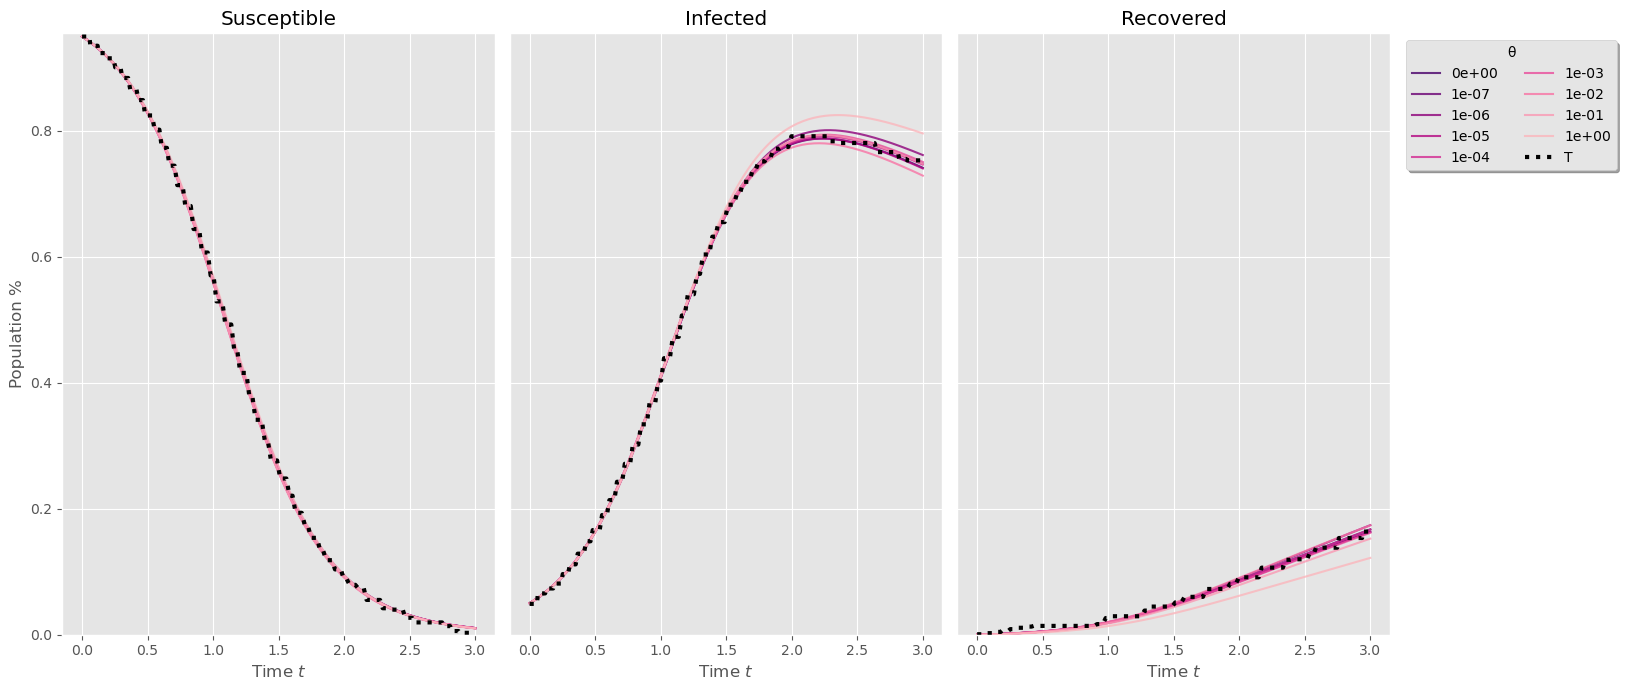

In [42]:
# Multiplot
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[1].set_yticklabels([]);
ax[2].set_yticklabels([]);
for tick in ax[1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
for tick in ax[2].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    '''tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)'''

k = colours_GD.shape[0] - 1
for θ, ρ in States.items():
    
    # Susceptible
    ax[0].plot(Tₑ, ρ[0]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Infected
    ax[1].plot(Tₑ, ρ[1]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Recovered
    ax[2].plot(Tₑ, ρ[2]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    k -= 1
    
# Add target
ax[0].plot(Tₑ, ρ̂[0]/n, ':', c='black', linewidth=3, label = 'T')
ax[1].plot(Tₑ, ρ̂[1]/n, ':', c='black', linewidth=3, label = 'T')
ax[2].plot(Tₑ, ρ̂[2]/n, ':', c='black', linewidth=3, label = 'T')

ax[0].set_ylim([0.0, (Sₒ+2)/n]);    ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_ylim([0.0, (Sₒ+2)/n]);    ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_ylim([0.0, (Sₒ+2)/n]);    ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')

ax[0].set_ylabel('Population %')

plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
plt.savefig('Outputs/Regularisation – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

[]

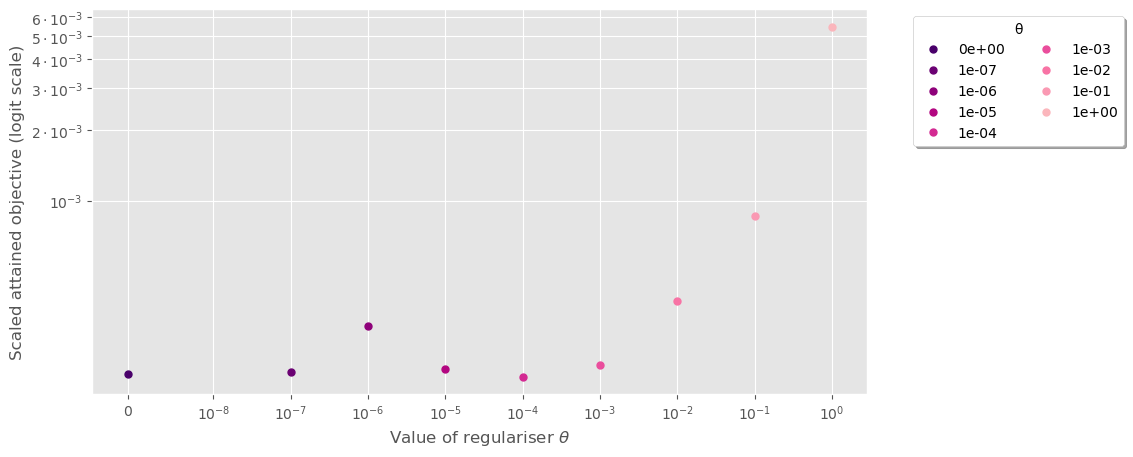

In [43]:
# Plot objective against θ
plt.figure(figsize=(10,5))

k = colours_GD.shape[0] - 1
for θ, fᵥ in Stats['obj'].items():
    
    # Susceptible
    plt.plot(θ, fᵥ, color = colours_GD[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='.', linestyle = '', markersize=10, 
             label = '{0:.0e}'.format(θ))
    
    k -= 1
    
    
plt.xscale('symlog', linthresh = 1e-8)
plt.yscale('logit')
plt.legend(bbox_to_anchor=(1.34, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')

plt.xlabel(r'Value of regulariser $\theta$');    plt.ylabel('Scaled attained objective (logit scale)')
plt.plot()

---

In [44]:
Stats

,it,obj,time,β,γ,m,df_β,df_γ,df_m,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.000000e+00,683,0.00018216193491721037,12.976192,0.007011,0.104485,0.050259,0.012005,0.005427,0.003185,0.006872,0.007826,0.012005,0.003185
1.000000e-07,531,0.00018576314230569268,10.615667,0.007015,0.101494,0.048307,1.761559,-0.012398,-0.011006,0.594988,1.017082,1.761559,0.011006
1.000000e-06,850,0.0002928280208966015,14.352290,0.006949,0.107380,0.033207,-0.214336,-0.007855,-0.016856,0.079682,0.124212,0.214336,0.007855
1.000000e-05,972,0.00019147142926876685,17.368802,0.007043,0.101730,0.053628,0.503064,0.000368,0.002799,0.168744,0.290449,0.503064,0.000368
1.000000e-04,837,0.00017774814295570514,16.138311,0.007005,0.103968,0.047193,0.440456,-0.001440,-0.003523,0.148473,0.254307,0.440456,0.001440
1.000000e-03,520,0.0001989993030017629,10.153611,0.006988,0.100474,0.047756,1.564011,-0.015371,-0.011932,0.530438,0.903052,1.564011,0.011932
1.000000e-02,593,0.00037341149979808473,10.343147,0.007074,0.109071,0.054521,-3.987461,0.038889,0.033584,1.353311,2.302353,3.987461,0.033584
1.000000e-01,601,0.0008617049627366459,9.211360,0.007036,0.094526,0.055433,1.586828,-0.013730,-0.003538,0.534699,0.916192,1.586828,0.003538
1.000000e+00,594,0.00548842322633462,8.217665,0.006867,0.073698,0.043428,1.880236,-0.034965,-0.014019,0.643073,1.085772,1.880236,0.014019


In [45]:
Stats.to_pickle('Outputs/Regularisation – FISTA - Final.pkl') # To read back use pd.read_pickle(file_name)

---